# **Von Heijne method implementation**

In [1]:
!pip install biopython

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.metrics import precision_recall_curve, confusion_matrix
import sklearn.metrics as skl
import sys
sys.path.append('../shared_code')
import Data_analysis as da

In [3]:
# Retrieve the aminoacid frequences from SwissProt
swiss_freq = {k: round((v / 100),4) for k, v in da.swiss_freq.items()}

In [4]:
print(swiss_freq)

{'A': 0.0825, 'Q': 0.0393, 'L': 0.0964, 'S': 0.0665, 'R': 0.0552, 'E': 0.0671, 'K': 0.0579, 'T': 0.0536, 'N': 0.0406, 'G': 0.0707, 'M': 0.0241, 'W': 0.011, 'D': 0.0546, 'H': 0.0227, 'F': 0.0386, 'Y': 0.0292, 'C': 0.0138, 'I': 0.059, 'P': 0.0474, 'V': 0.0685}


In [5]:
# Convert fasta format sequences into a pandas dataframe
seqs_df = pd.concat([da.fasta_to_dataframe("../2_data_preparation/clusters/cluster-results-neg_rep_seq.fasta"), da.fasta_to_dataframe("../2_data_preparation/clusters/cluster-results_rep_seq.fasta")], ignore_index=True)
seqs_df.shape

(10027, 2)

In [6]:
# Convert a tsv file into a pandas dataframe
training_df = pd.read_csv("../2_data_preparation/sets/training_set.tsv", sep="\t")
training_df.head()

,id,organism_name,kingdom,sequence_length,cleavage_site,validation_n,sp_type,transmembrane
0,Q99MA2,Rattus norvegicus,Metazoa,674,22.0,3,1,NaN
1,P17948,Homo sapiens,Metazoa,1338,26.0,1,1,NaN
2,P41271,Homo sapiens,Metazoa,181,16.0,1,1,NaN
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23.0,4,1,NaN
4,Q92154,Coturnix japonica,Metazoa,620,17.0,4,1,NaN


In [7]:
benchmark_df = pd.read_csv("../2_data_preparation/sets/test_set.tsv", sep='\t')
benchmark_df.head()

,id,organism_name,kingdom,sequence_length,cleavage_site,sp_type,transmembrane
0,A0A1S6EK92,Moringa oleifera,Viridiplantae,79,20.0,1,NaN
1,P19801,Homo sapiens,Metazoa,751,19.0,1,NaN
2,P79263,Sus scrofa,Metazoa,921,27.0,1,NaN
3,P21814,Ovis aries,Metazoa,429,25.0,1,NaN
4,P29421,Oryza sativa subsp. japonica,Viridiplantae,200,22.0,1,NaN


In [8]:
# Union of the sequences with the information dataframe
train_with_seq = training_df.merge(seqs_df, on="id", how="inner")
train_with_seq.to_csv('../2_data_preparation/sets/train_with_seq.tsv', sep='\t', index=False)
train_with_seq.tail()

,id,organism_name,kingdom,sequence_length,cleavage_site,validation_n,sp_type,transmembrane,sequence
8016,P87074,Schizosaccharomyces pombe (strain 972 / ATCC 2...,Fungi,778,NaN,4,0,False,MEVNDTSLHKGFGLDINSQRVFGAQAAISRNNYSKVNASINPSPPR...
8017,Q9H3N8,Homo sapiens,Metazoa,390,NaN,1,0,False,MPDTNSTINLSLSTRVTLAFFMSLVAFAIMLGNALVILAFVVDKNL...
8018,P32349,Saccharomyces cerevisiae (strain ATCC 204508 /...,Fungi,654,NaN,3,0,False,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...
8019,G5EGE9,Caenorhabditis elegans,Metazoa,1263,NaN,3,0,False,MDVPSSSNVTGRRKRQVLDDDEDDGFRSTPLRKVRGTKKIRPADVV...
8020,Q95339,Sus scrofa,Metazoa,88,NaN,5,0,True,MASVVPLKDRRLLEVKLGELPSWILMRDFTPSGIAGAFQRGYYRYY...


In [9]:
test_with_seq = benchmark_df.merge(seqs_df, on='id', how="inner")
test_with_seq.to_csv('../2_data_preparation/sets/test_with_seq.tsv', sep='\t', index=False)
test_with_seq.tail()

,id,organism_name,kingdom,sequence_length,cleavage_site,sp_type,transmembrane,sequence
2001,Q9SNB7,Arabidopsis thaliana,Viridiplantae,665,NaN,0,False,MQALSILPLKSGLLVGSRLEFELDCSCFVVSPKTTRKRLCFLEQAC...
2002,P56560,Bos taurus,Metazoa,520,NaN,0,False,MSSKCDVVVVGGGISGMAAAKLLHDSGLNVIVLEARDRVGGRTYTL...
2003,P24389,Rattus norvegicus,Metazoa,257,NaN,0,False,MGLSQLWLWLKRLVIFLQVALEVATGKVLMTLFPERVKQNILAMGQ...
2004,Q86UT6,Homo sapiens,Metazoa,975,NaN,0,False,MRWGHHLPRASWGSGFRRALQRPDDRIPFLIHWSWPLQGERPFGPP...
2005,Q9LSQ5,Arabidopsis thaliana,Viridiplantae,204,NaN,0,False,MATKVYIVYYSMYGHVEKLAEEIRKGAASVEGVEAKLWQVPETLHE...


In [10]:
def make_groups():
  ''' Function to create order the subsets for cross validation'''
  l = [_ for _ in range(5)]
  group = {}
  for i in l:
      print(f'{(i%5)+1} {((i+1)%5)+1} {((i+2)%5)+1} {((i+3)%5)+1} {((i+4)%5)+1}')
      train = (((i%5)+1 ,((i+1)%5)+1 ,((i+2)%5)+1))
      test = ((i+3)%5)+1
      cross_val = ((i+4)%5)+1
      name_run = f'Run_{i+1}'
      group[name_run] = (train, test, cross_val)
  return group

groups = make_groups()

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4


In [11]:
# Create a dictionary to store an index for each aminoacid
order = list("ARNDCQEGHILKMFPSTWYV")
index_aa = {}
for i, aa in enumerate(order):
  index_aa[aa]= i
print(index_aa)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [12]:
def vh_matrix_initialize(sequences_df, window:int, indexes):
  ''' Implements and initialize the von Heijne matrix'''
  PSPM = np.ones((window,20))

  for record in sequences_df['sp_cut']:
    temp_matrix = np.zeros((window,20))
    for i, aa in enumerate(record):
      if aa in indexes:
        col = indexes[aa]
        temp_matrix[i][col] += 1

    PSPM += temp_matrix
  return PSPM

In [13]:
def vh_matrix_calculus(PSPM, sequences_df, swiss_freq, indexes):
  x = PSPM/(len(sequences_df) +20)
  #Divide all the counts by the corresponding residue frequency in the SwissProtbackground distribution
  for key , val in indexes.items():
    x[:,val] /= swiss_freq[key]
  #log
  PSWM = np.log(x)
  return PSWM

In [14]:
def von_Heijne_matrix(sequences_df, window:int, swiss_freq, indexes):
  PSPM = vh_matrix_initialize(sequences_df, window, indexes)
  PSWM = vh_matrix_calculus(PSPM, sequences_df, swiss_freq, indexes)
  return PSWM
np.set_printoptions(edgeitems=10, linewidth=400)

In [15]:
def best_score_calculator(sequence, n_residues: int, window: int, PSWM, aa_index):
  sequence_scores = []
  for i in range(n_residues-window+1):
    window_seq = sequence[i:i+window]
    score = 0
    for j, aa in enumerate(window_seq):
      if aa in aa_index:
        score += PSWM[j, aa_index[aa]]
    sequence_scores.append(float(score))
  return max(sequence_scores)

In [16]:
def training_vonHeijne(training_set, train, indexes):
  tr_set = training_set[training_set['validation_n'].isin(train)]
  tr_set = tr_set.loc[tr_set["sp_type"]==1]
  tr_set['sp_cut'] = tr_set.apply(da.cut_sp_sequence_logo, axis=1)
  PSWM= von_Heijne_matrix(tr_set, 15, swiss_freq, indexes)
  return PSWM

In [17]:
def score_vonHeijne(dataset, pswm, aa_index):
  score = []
  for seq in dataset["sequence"]:
      seq_score = best_score_calculator(seq, 90, 15, pswm, aa_index)
      score.append(round(seq_score,3))
  return score

In [18]:
def validation_vonHeijne(training_set, validation, PSWM, indexes):
  validation_set = training_set[training_set['validation_n'] == validation]
  validation_scores = score_vonHeijne(validation_set, PSWM, indexes)
  y_validation = validation_set["sp_type"].to_list()
  precision, recall, thresholds = precision_recall_curve(y_validation, validation_scores)
  fscore = (2 * precision * recall) / (precision + recall)
  index = np.argmax(fscore)
  optimal_threshold = thresholds[index]
  return optimal_threshold, validation_scores, y_validation

In [19]:
def test_vonHeijne(training_set, test, optimal_threshold, PSWM, indexes):
  test_set = training_set[training_set['validation_n'] == test]
  test_scores = score_vonHeijne(test_set, PSWM, indexes)
  y_pred_test = [int(t_s >= optimal_threshold) for t_s in test_scores]
  obs_test = test_set["sp_type"].to_list()
  return y_pred_test, obs_test

In [20]:
def metrics(obs_test, y_pred_test):
  MCC = skl.matthews_corrcoef(obs_test, y_pred_test)            # Matthews Correlation Coefficient
  ACC = skl.accuracy_score(obs_test, y_pred_test)               # Accuracy
  PPV = skl.precision_score(obs_test, y_pred_test)              # Precision
  SEN = skl.recall_score(obs_test, y_pred_test)                 # Recall
  CONF =skl.confusion_matrix(obs_test , y_pred_test)            # Confusion Matrix
  F1_SCORE = skl.f1_score(obs_test, y_pred_test)                # F1 score
  return MCC, ACC, PPV, SEN, CONF, F1_SCORE

In [21]:
def plot_pr_and_confusion(y_true, y_scores, y_test, y_pred_test, optimal_threshold=None, labels=None, run_id = None):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    suffix = f"{run_id}" if run_id is not None else ""
    fig.suptitle(f'{suffix}')
    

    # Precision–Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    axes[0].plot(recall, precision, marker=".", label="PR curve")
    if optimal_threshold is not None:
        idx = (np.abs(thresholds - optimal_threshold)).argmin()
        axes[0].scatter(recall[idx], precision[idx], color="red", s=80,
                        label=f"Threshold={optimal_threshold:.2f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision–Recall curve")
    axes[0].legend()
    axes[0].grid(True)

    # Confusion Matrix 
    cm = confusion_matrix(y_test, y_pred_test, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1])
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_title("Confusion Matrix")

    plt.tight_layout()
    filename = f"pr_and_confusion{suffix}.png"
    plt.savefig(filename)
    plt.show()

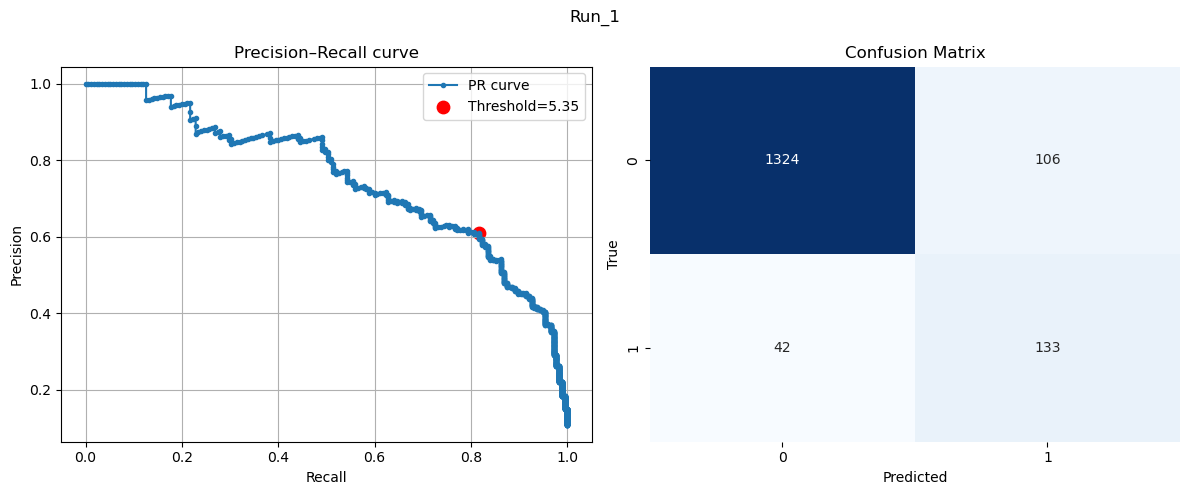

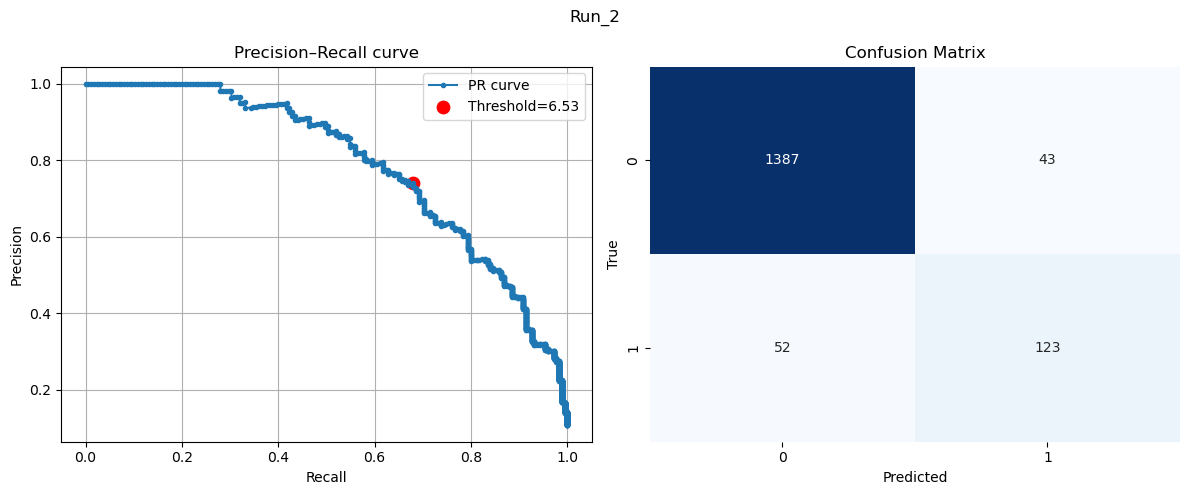

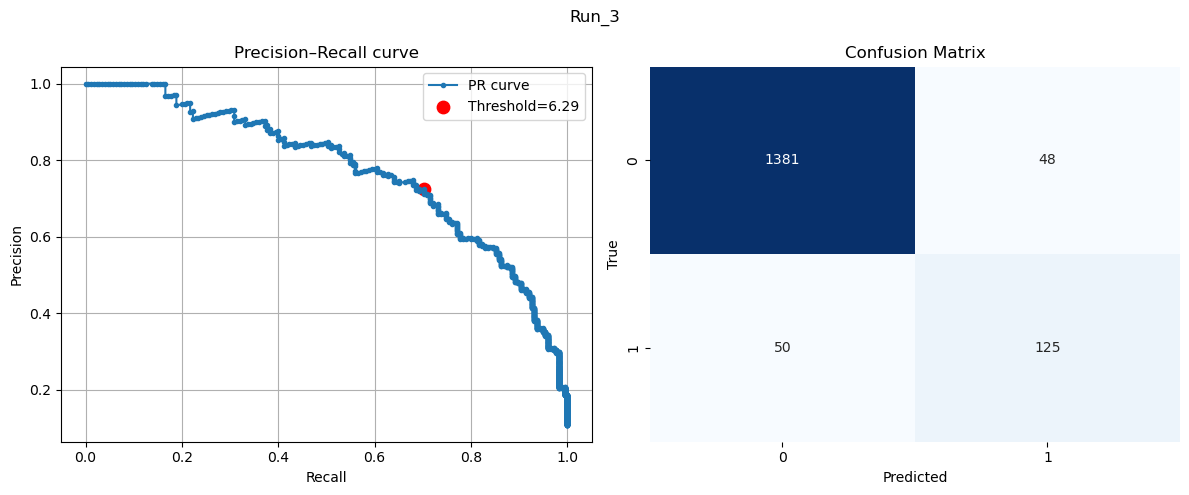

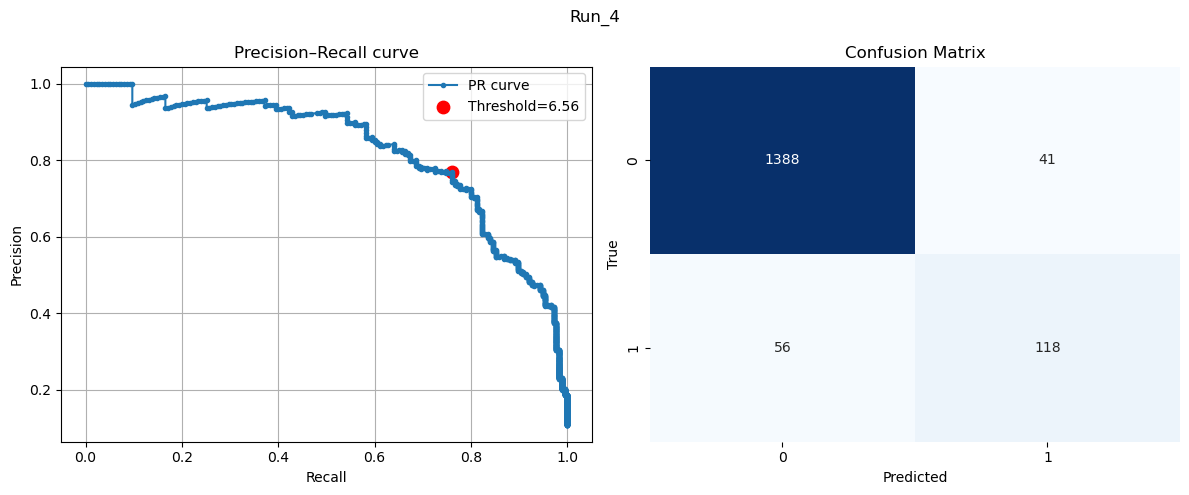

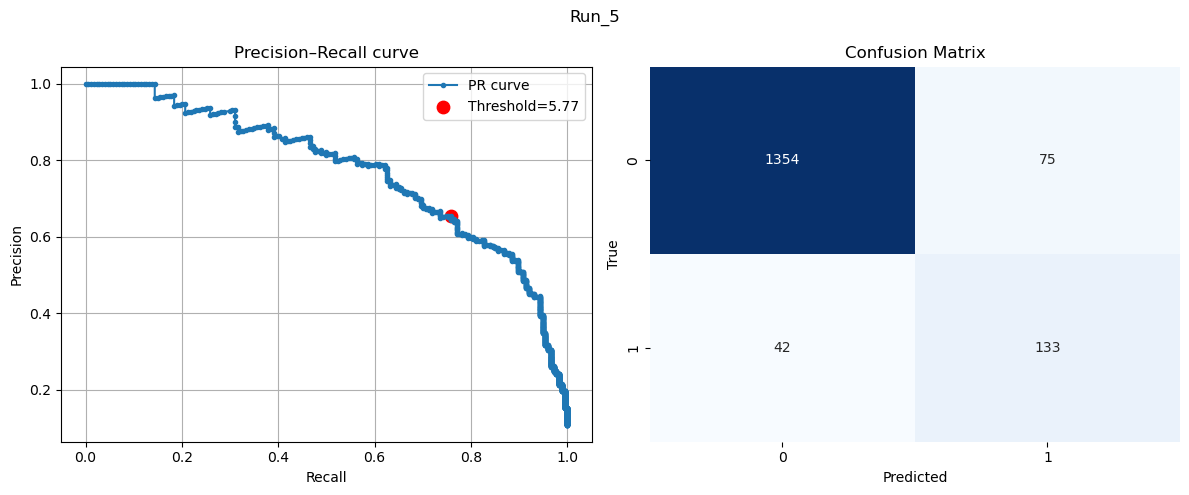

,MCC,ACC,PPV,SEN,F1_SCORE,threshold
0,0.661145,0.930809,0.680311,0.723061,0.697107,6.1


In [22]:
all_metrics = []
for key, value in groups.items():
    train, validation, test = value
    PSWM = training_vonHeijne(train_with_seq, train, index_aa)
    optimal_threshold, validation_scores, y_validation = validation_vonHeijne(train_with_seq, validation, PSWM, index_aa)
    y_pred_test, obs_test = test_vonHeijne(train_with_seq, test, optimal_threshold, PSWM, index_aa)

    MCC, ACC, PPV, SEN, CONF, F1_SCORE = metrics(obs_test, y_pred_test)
    all_metrics.append([MCC, ACC, PPV, SEN, F1_SCORE, optimal_threshold])
    plot_pr_and_confusion(
    y_validation,
    validation_scores,
    obs_test,
    y_pred_test,
    optimal_threshold,
    labels=[0,1],
    run_id=key
    )
avg_metrics = np.mean(np.array(all_metrics), axis=0)
means = pd.DataFrame([avg_metrics], columns=['MCC', 'ACC', 'PPV', 'SEN', 'F1_SCORE', 'threshold'])
means

# **Evaluation on benchmarking set**

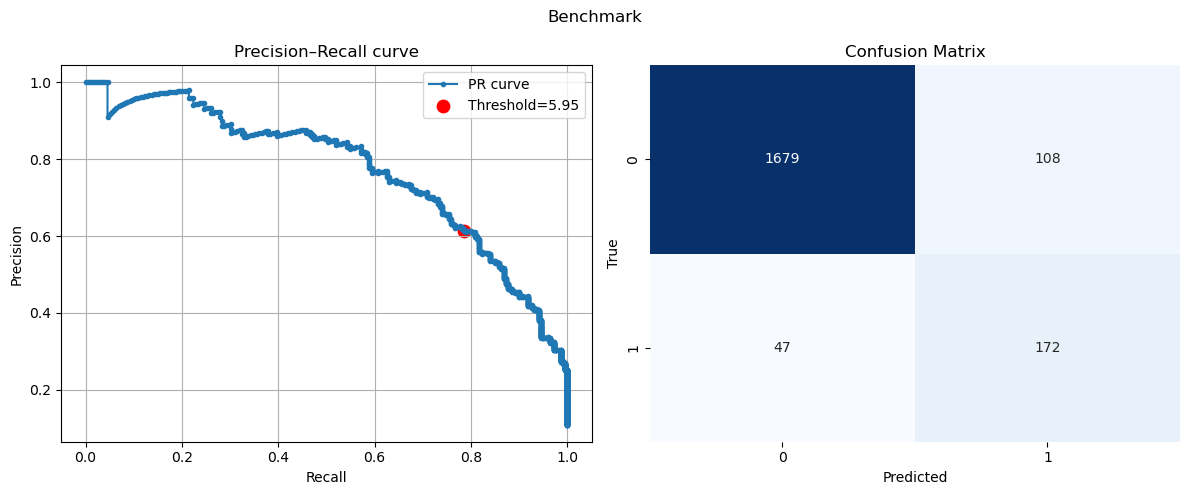

       MCC       ACC       PPV       SEN  F1_SCORE  threshold
0  0.65237  0.922732  0.614286  0.785388  0.689379      5.949


In [23]:
test_performances = []
train = [1,2,3,4]
final_train = training_vonHeijne(train_with_seq, train, index_aa)
validation = validation_vonHeijne(train_with_seq, 5, final_train, index_aa)
threshold = validation[0]
test = score_vonHeijne(test_with_seq, final_train, index_aa)
y_prediction_test = [int(t_s >= threshold) for t_s in test]
target = test_with_seq['sp_type'].to_list()
mcc, acc, ppv, sen, conf, f1_score = metrics(target, y_prediction_test)
test_performances.append([mcc, acc, ppv, sen, f1_score, threshold])
plot_pr_and_confusion(
    target,
    test,
    target,
    y_prediction_test,
    threshold,
    labels=[0,1],
    run_id="Benchmark")
results_summary = pd.DataFrame(test_performances, columns=['MCC', 'ACC', 'PPV', 'SEN', 'F1_SCORE', 'threshold'])
print(results_summary)